<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



# Access Popular LLMs via Google-Colab-AI Without an API Key

Users with Colab's paid plans have free access to most popular LLMs via google-colab-ai Python library. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).

In [1]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

The capital of France is **Paris**.



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [3]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


Training BI-LSTM decoder...
Epoch 1/20 - Train Loss: 0.6886, Val Loss: 0.6847
Epoch 2/20 - Train Loss: 0.6782, Val Loss: 0.6772
Epoch 3/20 - Train Loss: 0.6636, Val Loss: 0.6588
Epoch 4/20 - Train Loss: 0.6453, Val Loss: 0.6422
Epoch 5/20 - Train Loss: 0.6214, Val Loss: 0.6339
Epoch 6/20 - Train Loss: 0.5860, Val Loss: 0.5851
Epoch 7/20 - Train Loss: 0.5662, Val Loss: 0.5785
Epoch 8/20 - Train Loss: 0.5555, Val Loss: 0.5631
Epoch 9/20 - Train Loss: 0.5376, Val Loss: 0.5464
Epoch 10/20 - Train Loss: 0.5350, Val Loss: 0.5408
Epoch 11/20 - Train Loss: 0.5105, Val Loss: 0.5296
Epoch 12/20 - Train Loss: 0.5089, Val Loss: 0.5304
Epoch 13/20 - Train Loss: 0.5042, Val Loss: 0.5284
Epoch 14/20 - Train Loss: 0.5018, Val Loss: 0.5240
Epoch 15/20 - Train Loss: 0.4979, Val Loss: 0.5231
Epoch 16/20 - Train Loss: 0.4975, Val Loss: 0.5226
Epoch 17/20 - Train Loss: 0.4965, Val Loss: 0.5166
Epoch 18/20 - Train Loss: 0.4939, Val Loss: 0.5199
Epoch 19/20 - Train Loss: 0.4934, Val Loss: 0.5203
Epoch 20/20 

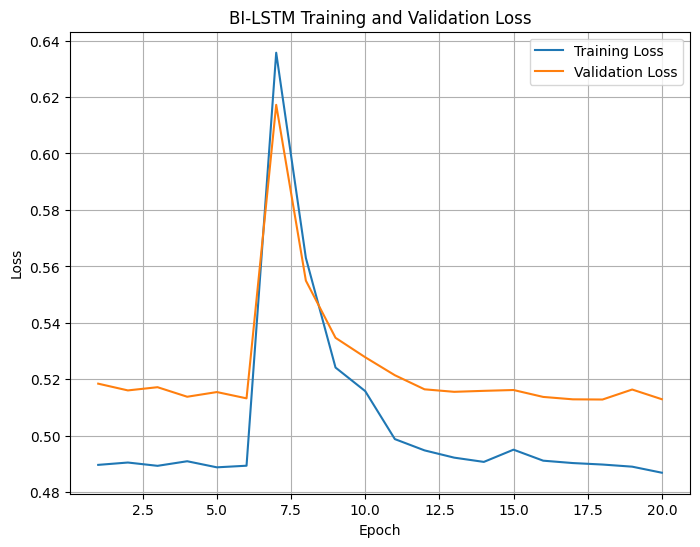

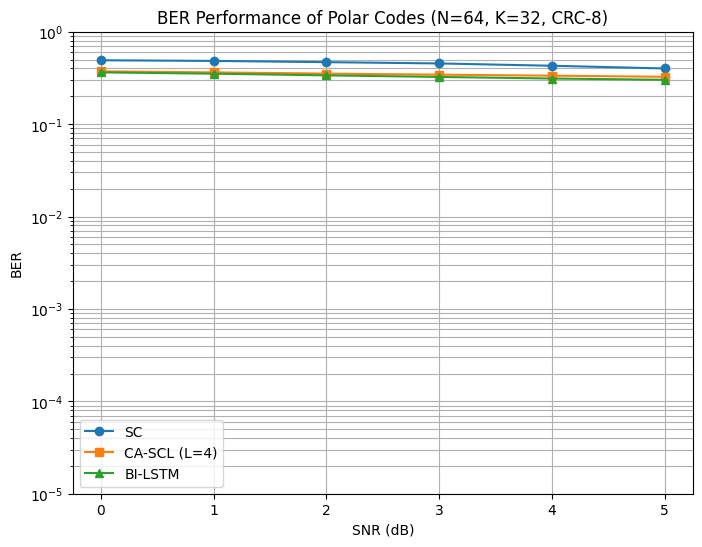

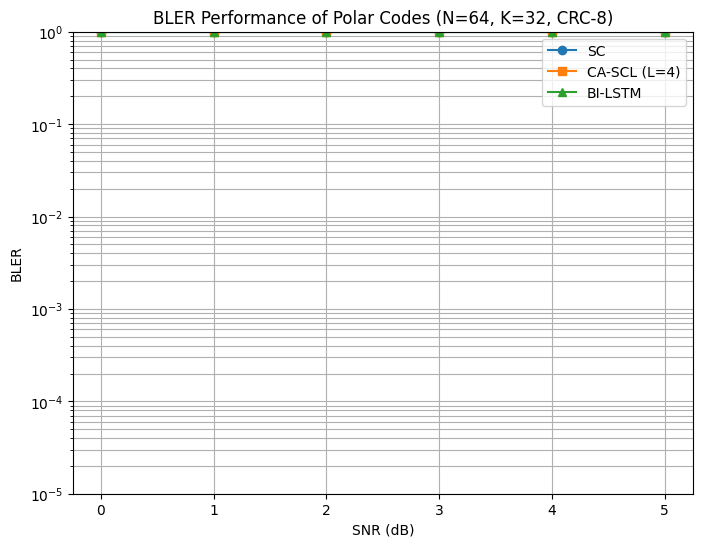

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# Config
N = 64
K = 32
CRC_LEN = 8
RATE = K / N
SNR_RANGE_DB = np.arange(0, 6, 1)  # 0 to 5 dB by 1 dB step
NUM_FRAMES = 5000

HIDDEN_SIZE = 64
NUM_LAYERS = 2
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CRC-8 functions
CRC_POLY = 0x07

def crc8_encode(bits):
    data = bits.copy()
    crc = 0
    for b in data:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    crc_bits = [(crc >> i) & 1 for i in reversed(range(8))]
    return np.concatenate([data, crc_bits])

def crc8_check(bits):
    crc = 0
    for b in bits:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    return crc == 0

# Arikan sequence for N=64 from 3GPP 38.212
ARIKAN_SEQ_64 = [
    0, 1, 2, 4, 8, 16, 32, 3,
    5, 9, 17, 33, 6, 10, 18, 34,
    12, 24, 48, 7, 11, 19, 35, 13,
    25, 49, 14, 26, 50, 28, 36, 52,
    15, 27, 51, 29, 37, 53, 30, 38,
    54, 31, 39, 55, 40, 56, 41, 57,
    42, 58, 43, 59, 44, 60, 45, 61,
    46, 62, 47, 63
]

class PolarCode:
    def __init__(self, N, K, crc_len, reliab_seq):
        self.N = N
        self.K = K
        self.crc_len = crc_len
        self.info_len = K - crc_len
        self.reliab_seq = reliab_seq
        self.frozen_bits = np.ones(N, dtype=bool)
        self.info_positions = np.sort(reliab_seq[:K])
        self.frozen_bits[self.info_positions] = False

    def encode(self, u):
        # u is info bits excluding CRC, length = info_len
        u_crc = crc8_encode(u)  # length K
        x = np.zeros(self.N, dtype=int)
        x[self.info_positions] = u_crc  # place info+CRC bits in info positions
        n = self.N
        stage = 1
        while stage < n:
            for i in range(0, n, 2*stage):
                for j in range(stage):
                    x[i+j] ^= x[i+j+stage]
            stage *= 2
        return x

polar = PolarCode(N, K, CRC_LEN, ARIKAN_SEQ_64)

def bpsk_mod(bits):
    return 1 - 2 * bits

def awgn_channel(s, snr_db):
    snr_linear = 10**(snr_db / 10)
    sigma2 = 1 / (2 * RATE * snr_linear)  # noise variance per real dim
    sigma = math.sqrt(sigma2)
    noise = sigma * np.random.randn(*s.shape)
    y = s + noise
    llr = 2 * y / sigma2
    return y, llr

def sc_decode(llr, frozen_mask):
    N = len(llr)
    def recurse(llr_sub, mask_sub):
        n = len(llr_sub)
        if n == 1:
            if mask_sub[0]:
                return np.array([0], dtype=int)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=int)
        half = n // 2
        llr_left = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i + half]
            llr_left[i] = np.sign(a) * np.sign(b) * min(abs(a), abs(b))
        mask_left = mask_sub[:half]
        u_hat_left = recurse(llr_left, mask_left)
        llr_right = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i + half]
            llr_right[i] = b + ((1 - 2*u_hat_left[i]) * a)
        mask_right = mask_sub[half:]
        u_hat_right = recurse(llr_right, mask_right)
        u = np.zeros(n, dtype=int)
        for i in range(half):
            u[i] = u_hat_left[i] ^ u_hat_right[i]
            u[i+half] = u_hat_right[i]
        return u
    u_hat = recurse(llr, frozen_mask)
    return u_hat

def scl_decode(llr, frozen_mask, list_size=4):
    # Simplified SCL decoder with CRC check for list_size=4
    N = len(llr)
    paths = [{'u': np.zeros(0, dtype=int), 'metric': 0.0}]
    for phi in range(N):
        new_paths = []
        is_frozen = frozen_mask[phi]
        for path in paths:
            prefix = path['u']
            base_metric = path['metric']
            if is_frozen:
                bit = 0
                l = llr[phi]
                pen = abs(l) if (l < 0) else 0.0
                new_u = np.concatenate([prefix, np.array([bit], dtype=int)])
                new_paths.append({'u': new_u, 'metric': base_metric + pen})
            else:
                for bit in (0,1):
                    l = llr[phi]
                    pen = 0.0
                    if (l >= 0 and bit == 1) or (l < 0 and bit == 0):
                        pen += abs(l)
                    new_u = np.concatenate([prefix, np.array([bit], dtype=int)])
                    new_paths.append({'u': new_u, 'metric': base_metric + pen})
        new_paths = sorted(new_paths, key=lambda p: p['metric'])
        paths = new_paths[:list_size]
    # Pick candidate with valid CRC and lowest metric
    candidates = []
    for p in paths:
        u_vec = p['u']
        info_vec = u_vec[polar.info_positions]
        if crc8_check(info_vec):
            candidates.append((p['metric'], info_vec))
    if candidates:
        candidates = sorted(candidates, key=lambda x: x[0])
        chosen_info = candidates[0][1]
    else:
        # Pick best metric if no candidate passed CRC
        chosen_info = paths[0]['u'][polar.info_positions]
    return chosen_info

class BiLSTMDecoder(nn.Module):
    def __init__(self, input_len, hidden_size=64, num_layers=2):
        super(BiLSTMDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, K)  # Output K bits: info + CRC
        )
    def forward(self, x):
        # x shape: (batch, N)
        x = x.unsqueeze(-1)  # (batch, N, 1)
        out, _ = self.lstm(x)  # (batch, N, 2*hidden)
        pooled = out.mean(dim=1)  # (batch, 2*hidden)
        logits = self.fc(pooled)  # (batch, K)
        return logits

# Training function
def train_bilstm(model, optimizer, criterion, epochs, batch_size, snr_db):
    model.train()
    epoch_losses = []
    for epoch in range(epochs):
        losses = []
        steps = 200
        for _ in range(steps):
            s_batch = []
            target_batch = []
            train_snr_db = np.random.uniform(snr_db, snr_db + 2)
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)
                u_crc = crc8_encode(u_msg)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                s_batch.append(s)
                target_batch.append(u_crc.astype(np.float32))
            s_batch = np.stack(s_batch)
            _, llr_batch = awgn_channel(s_batch, train_snr_db)
            inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)
            optimizer.zero_grad()
            logits = model(inp)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
            loss = criterion(outputs, tgt)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_loss = np.mean(losses)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")
    return epoch_losses

# BI-LSTM decoder wrapper for evaluation - batch size 1 input
def bilstm_decoder_func(llr):
    model.eval()
    with torch.no_grad():
        inp = torch.tensor(llr, dtype=torch.float32).unsqueeze(0).to(device)  # (1, N)
        out = model(inp)  # (1, K)
        probs = torch.sigmoid(out).cpu().numpy()[0]
        bits_hat = (probs >= 0.5).astype(int)
        return bits_hat

# Evaluate function - handles SC/SCL (return info bits) and BI-LSTM (return info bits)

def train_bilstm(model, optimizer, criterion, epochs, batch_size, snr_db):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = []
        steps = 200
        for _ in range(steps):
            s_batch = []
            target_batch = []
            train_snr_db = np.random.uniform(snr_db, snr_db + 2)
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)
                u_crc = crc8_encode(u_msg)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                s_batch.append(s)
                target_batch.append(u_crc.astype(np.float32))
            s_batch = np.stack(s_batch)
            _, llr_batch = awgn_channel(s_batch, train_snr_db)
            inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)
            optimizer.zero_grad()
            logits = model(inp)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
            loss = criterion(outputs, tgt)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_train_loss = np.mean(losses)
        train_losses.append(avg_train_loss)

        # Validation loss (fixed SNR for validation)
        val_loss = evaluate_loss(model, criterion, num_batches=20, batch_size=batch_size, snr_db=snr_db)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
    return train_losses, val_losses
#########################################################################################

def evaluate_loss(model, criterion, num_batches=20, batch_size=64, snr_db=2.0):
    model.eval()
    losses = []
    with torch.no_grad():
        for _ in range(num_batches):
            s_batch = []
            target_batch = []
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)
                u_crc = crc8_encode(u_msg)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                s_batch.append(s)
                target_batch.append(u_crc.astype(np.float32))
            s_batch = np.stack(s_batch)
            _, llr_batch = awgn_channel(s_batch, snr_db)
            inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)
            logits = model(inp)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
            loss = criterion(outputs, tgt)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

def train_bilstm(model, optimizer, criterion, epochs, batch_size, snr_db):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = []
        steps = 200
        for _ in range(steps):
            s_batch = []
            target_batch = []
            train_snr_db = np.random.uniform(snr_db, snr_db + 2)
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)
                u_crc = crc8_encode(u_msg)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                s_batch.append(s)
                target_batch.append(u_crc.astype(np.float32))
            s_batch = np.stack(s_batch)
            _, llr_batch = awgn_channel(s_batch, train_snr_db)
            inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)
            optimizer.zero_grad()
            logits = model(inp)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
            loss = criterion(outputs, tgt)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_train_loss = np.mean(losses)
        train_losses.append(avg_train_loss)

        # Validation loss (fixed SNR for validation)
        val_loss = evaluate_loss(model, criterion, num_batches=20, batch_size=batch_size, snr_db=snr_db)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
    return train_losses, val_losses
##############################################################################################


###################################
def evaluate_decoder(decoder_func, snr_range_db, num_frames):
    ber = []
    bler = []
    for snr_db in snr_range_db:
        bit_errors = 0
        block_errors = 0
        total_bits = 0
        for _ in range(num_frames):
            u_msg = np.random.randint(0, 2, polar.info_len)
            u_crc = crc8_encode(u_msg)
            x = polar.encode(u_msg)
            s = bpsk_mod(x)
            _, llr = awgn_channel(s, snr_db)
            # Decode
            bits_hat = decoder_func(llr)
            # bits_hat is info bits + crc bits
            bit_errors += np.sum(bits_hat != u_crc)
            total_bits += len(u_crc)
            if not np.array_equal(bits_hat, u_crc):
                block_errors += 1
        ber.append(bit_errors / total_bits)
        bler.append(block_errors / num_frames)
        print(f"SNR {snr_db} dB - BER: {ber[-1]:.5f}, BLER: {bler[-1]:.5f}")
    return ber, bler

# Wrappers to make decoder_func return info bits + CRC bits for SC and SCL
def sc_wrapper(llr):
    u_hat = sc_decode(llr, polar.frozen_bits)
    # Return only info positions bits (info + CRC)
    return u_hat[polar.info_positions]

def scl4_wrapper(llr):
    return scl_decode(llr, polar.frozen_bits, list_size=4)

# Instantiate model, optimizer, criterion
model = BiLSTMDecoder(N, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

# Train BI-LSTM
print("Training BI-LSTM decoder...")
train_bilstm(model, optimizer, criterion, EPOCHS, BATCH_SIZE, snr_db=2.0)

# Evaluate all decoders
print("Evaluating SC decoder...")
ber_sc, bler_sc = evaluate_decoder(sc_wrapper, SNR_RANGE_DB, NUM_FRAMES)

print("Evaluating CA-SCL decoder (L=4)...")
ber_scl4, bler_scl4 = evaluate_decoder(scl4_wrapper, SNR_RANGE_DB, NUM_FRAMES)

print("Evaluating BI-LSTM decoder...")
ber_nn, bler_nn = evaluate_decoder(bilstm_decoder_func, SNR_RANGE_DB, NUM_FRAMES)

######################################################################################
train_losses, val_losses = train_bilstm(model, optimizer, criterion, EPOCHS, BATCH_SIZE, snr_db=2.0)

plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BI-LSTM Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot BER
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, ber_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, ber_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, ber_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.ylim(1e-5, 1)
plt.grid(True, which='both')
plt.legend()
plt.title('BER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.show()

# Plot BLER
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, bler_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, bler_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, bler_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('BLER')
plt.ylim(1e-5, 1)
plt.grid(True, which='both')
plt.legend()
plt.title('BLER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.show()

Using device: cpu
Training BI-LSTM decoder...
Epoch 1/30 | Train Loss: 0.6891 | Val Loss: 0.6834
Epoch 2/30 | Train Loss: 0.6787 | Val Loss: 0.6746
Epoch 3/30 | Train Loss: 0.6667 | Val Loss: 0.6565
Epoch 4/30 | Train Loss: 0.6363 | Val Loss: 0.6203
Epoch 5/30 | Train Loss: 0.6004 | Val Loss: 0.5799
Epoch 6/30 | Train Loss: 0.5673 | Val Loss: 0.5510
Epoch 7/30 | Train Loss: 0.5461 | Val Loss: 0.5353
Epoch 8/30 | Train Loss: 0.5256 | Val Loss: 0.5182
Epoch 9/30 | Train Loss: 0.5154 | Val Loss: 0.5100
Epoch 10/30 | Train Loss: 0.5039 | Val Loss: 0.5035
Epoch 11/30 | Train Loss: 0.5048 | Val Loss: 0.5012
Epoch 12/30 | Train Loss: 0.5021 | Val Loss: 0.5014
Epoch 13/30 | Train Loss: 0.4995 | Val Loss: 0.4991
Epoch 14/30 | Train Loss: 0.5117 | Val Loss: 0.5001
Epoch 15/30 | Train Loss: 0.4993 | Val Loss: 0.4936
Epoch 16/30 | Train Loss: 0.4960 | Val Loss: 0.4944
Epoch 17/30 | Train Loss: 0.4967 | Val Loss: 0.4938
Epoch 18/30 | Train Loss: 0.4957 | Val Loss: 0.4926
Epoch 19/30 | Train Loss: 0

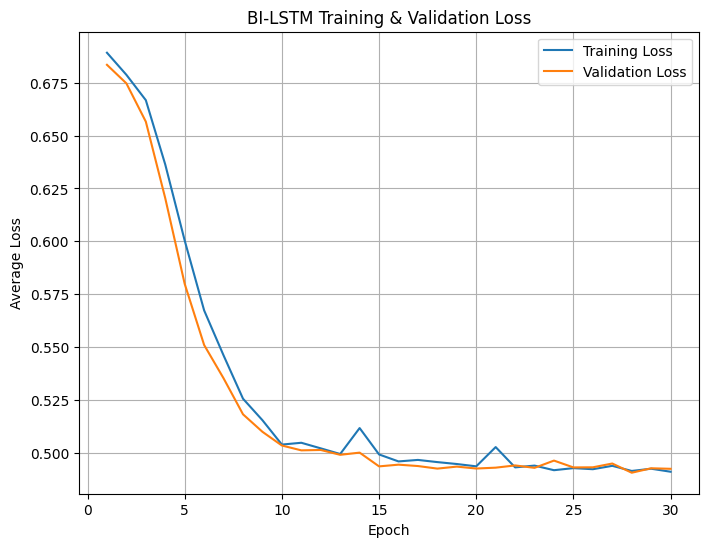

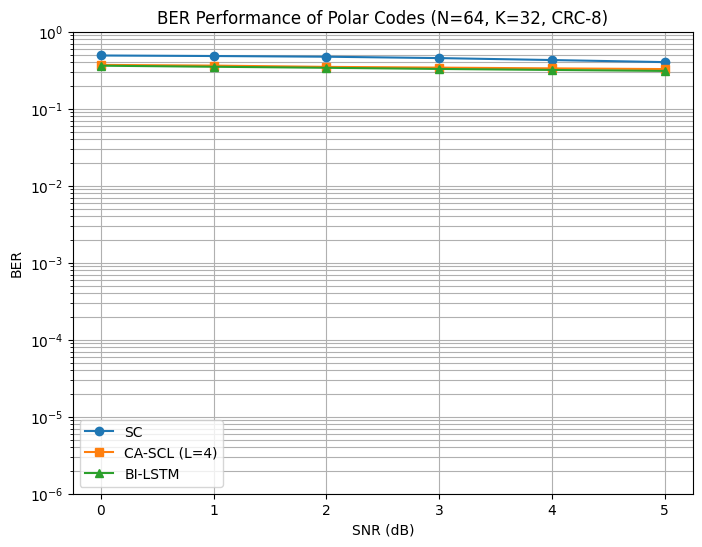

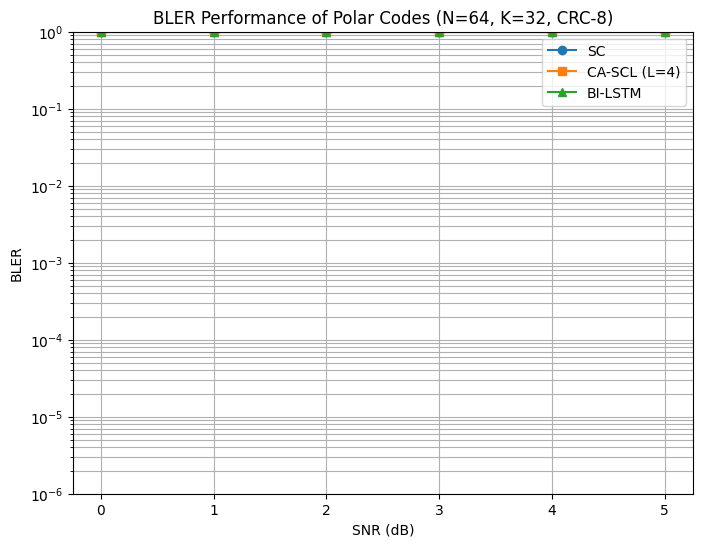

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# --- Config ---
N = 64
K = 32
CRC_LEN = 8
RATE = K / N
SNR_RANGE_DB = np.arange(0, 6, 1)  # 0 to 5 dB
NUM_FRAMES = 15000  # increased for final runs

HIDDEN_SIZE = 64
NUM_LAYERS = 2
EPOCHS = 30  # increased for final runs
BATCH_SIZE = 64
LEARNING_RATE = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- CRC-8 (x^8 + x^2 + x + 1) ---
CRC_POLY = 0x07

def crc8_encode(bits):
    bits = bits.copy()
    crc = 0
    for b in bits:
        crc ^= (b << 7)
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    crc_bits = [(crc >> i) & 1 for i in reversed(range(8))]
    return np.concatenate([bits, crc_bits])

def crc8_check(bits):
    crc = 0
    for b in bits:
        crc ^= (b << 7)
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    return crc == 0

# --- Arikan reliability sequence for N=64 ---
ARIKAN_SEQ_64 = [
    0, 1, 2, 4, 8, 16, 32, 3,
    5, 9, 17, 33, 6, 10, 18, 34,
    12, 24, 48, 7, 11, 19, 35, 13,
    25, 49, 14, 26, 50, 28, 36, 52,
    15, 27, 51, 29, 37, 53, 30, 38,
    54, 31, 39, 55, 40, 56, 41, 57,
    42, 58, 43, 59, 44, 60, 45, 61,
    46, 62, 47, 63
]

# --- Polar code class ---
class PolarCode:
    def __init__(self, N, K, crc_len, reliab_seq):
        self.N = N
        self.K = K
        self.crc_len = crc_len
        self.info_len = K - crc_len
        self.reliab_seq = reliab_seq
        self.frozen_bits = np.ones(N, dtype=bool)  # True means frozen
        self.info_positions = np.sort(reliab_seq[:K])
        self.frozen_bits[self.info_positions] = False

    def encode(self, u):
        # u is info bits only (length info_len)
        u_crc = crc8_encode(u)  # length K
        x = np.zeros(self.N, dtype=int)
        x[self.info_positions] = u_crc
        # Polar transform (Arikan's construction)
        n = self.N
        stage = 1
        while stage < n:
            for i in range(0, n, 2*stage):
                for j in range(stage):
                    x[i+j] ^= x[i+j+stage]
            stage <<= 1
        return x

polar = PolarCode(N, K, CRC_LEN, ARIKAN_SEQ_64)

# --- Modulation & channel ---
def bpsk_mod(bits):
    return 1 - 2*bits

def awgn_channel(s, snr_db):
    snr_linear = 10**(snr_db/10)
    sigma2 = 1/(2*RATE*snr_linear)
    sigma = math.sqrt(sigma2)
    noise = sigma * np.random.randn(*s.shape)
    y = s + noise
    llr = 2 * y / sigma2
    return y, llr

# --- SC decoder ---
def sc_decode(llr, frozen_mask):
    N = len(llr)

    def recurse(llr_sub, mask_sub):
        n = len(llr_sub)
        if n == 1:
            if mask_sub[0]:
                return np.array([0], dtype=int)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=int)
        half = n // 2
        llr_left = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i+half]
            llr_left[i] = np.sign(a)*np.sign(b)*min(abs(a), abs(b))
        mask_left = mask_sub[:half]
        u_hat_left = recurse(llr_left, mask_left)
        llr_right = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i+half]
            llr_right[i] = b + ((1 - 2*u_hat_left[i]) * a)
        mask_right = mask_sub[half:]
        u_hat_right = recurse(llr_right, mask_right)
        u = np.zeros(n, dtype=int)
        for i in range(half):
            u[i] = u_hat_left[i] ^ u_hat_right[i]
            u[i+half] = u_hat_right[i]
        return u

    u_hat = recurse(llr, frozen_mask)
    # Inverse Polar transform
    x = u_hat.copy()
    stage = 1
    while stage < N:
        for i in range(0, N, 2*stage):
            for j in range(stage):
                x[i+j+stage] ^= x[i+j]
        stage <<= 1
    return x, u_hat

# --- CA-SCL decoder (simplified) ---
def scl_decode(llr, frozen_mask, list_size=4):
    N = len(llr)
    paths = [{'u': np.zeros(0, dtype=int), 'metric': 0.0}]
    for phi in range(N):
        new_paths = []
        is_frozen = frozen_mask[phi]

        for path in paths:
            prefix = path['u']
            base_metric = path['metric']
            # For simplicity, use llr[phi] as likelihood estimate
            l = llr[phi]
            if is_frozen:
                bit = 0
                pen = abs(l) if (l < 0) else 0.0
                new_u = np.concatenate([prefix, [bit]])
                new_paths.append({'u': new_u, 'metric': base_metric + pen})
            else:
                for bit in [0, 1]:
                    pen = 0.0
                    if (l >= 0 and bit == 1) or (l < 0 and bit == 0):
                        pen += abs(l)
                    new_u = np.concatenate([prefix, [bit]])
                    new_paths.append({'u': new_u, 'metric': base_metric + pen})

        new_paths = sorted(new_paths, key=lambda p: p['metric'])
        paths = new_paths[:list_size]

    candidates = []
    for p in paths:
        u_vec = p['u']
        info_vec = u_vec[polar.info_positions]
        if crc8_check(info_vec):
            candidates.append((p['metric'], info_vec))

    if candidates:
        candidates = sorted(candidates, key=lambda x: x[0])
        chosen_info = candidates[0][1]
    else:
        # If no CRC pass, pick best metric path anyway
        chosen_info = paths[0]['u'][polar.info_positions]

    # Reconstruct full codeword with chosen info bits
    x = np.zeros(N, dtype=int)
    x[polar.info_positions] = chosen_info
    # Inverse Polar transform
    x_c = x.copy()
    stage = 1
    while stage < N:
        for i in range(0, N, 2*stage):
            for j in range(stage):
                x_c[i+j+stage] ^= x_c[i+j]
        stage <<= 1
    return x_c, chosen_info

# --- BI-LSTM Decoder ---
class BiLSTMDecoder(nn.Module):
    def __init__(self, input_len, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_len=K):
        super(BiLSTMDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, output_len)
        )

    def forward(self, x):
        # x shape: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        out, _ = self.lstm(x)  # (batch, seq_len, 2*hidden)
        pooled = out.mean(dim=1)  # average pooling over seq_len -> (batch, 2*hidden)
        logits = self.fc(pooled)  # (batch, output_len)
        return logits
###########################################Latest version
#Bilstm
# --- Training function with validation ---
def train_bilstm(model, optimizer, criterion, epochs, batch_size, snr_db, val_snr_db=3.0, val_batches=50):
    model.to(device)
    epoch_train_losses = []  # Avg training loss per epoch
    epoch_val_losses = []    # Avg validation loss per epoch

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_losses = []
        steps = 200
        for _ in range(steps):
            batch_s = []
            target_batch = []
            # Random SNR for this batch
            train_snr = np.random.uniform(snr_db, snr_db + 2)
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)
                u_crc = crc8_encode(u_msg)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                batch_s.append(s)
                target_batch.append(u_crc.astype(np.float32))
            batch_s = np.stack(batch_s)
            _, llr_batch = awgn_channel(batch_s, train_snr)

            inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)

            optimizer.zero_grad()
            logits = model(inp)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
            loss = criterion(outputs, tgt)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        epoch_train_losses.append(avg_train_loss)

        # ---- Validation ----
        model.eval()
        val_losses = []
        with torch.no_grad():
            for _ in range(val_batches):
                batch_s = []
                target_batch = []
                for _ in range(batch_size):
                    u_msg = np.random.randint(0, 2, polar.info_len)
                    u_crc = crc8_encode(u_msg)
                    x = polar.encode(u_msg)
                    s = bpsk_mod(x)
                    batch_s.append(s)
                    target_batch.append(u_crc.astype(np.float32))
                batch_s = np.stack(batch_s)
                _, llr_batch = awgn_channel(batch_s, val_snr_db)

                inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
                tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)

                logits = model(inp)
                outputs = torch.sigmoid(logits)
                outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
                loss = criterion(outputs, tgt)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)
        epoch_val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return epoch_train_losses, epoch_val_losses
########################################################


#########################################################
# --- Training function ---


# --- Evaluation function ---
def evaluate_decoder(decoder_func, snr_range_db, num_frames, batch_size=BATCH_SIZE):
    ber = []
    bler = []
    for snr_db in snr_range_db:
        bit_errors = 0
        block_errors = 0
        total_bits = 0
        # Process frames in batches
        for i in range(0, num_frames, batch_size):
            batch_size_i = min(batch_size, num_frames - i)
            batch_u_msg = np.random.randint(0, 2, (batch_size_i, polar.info_len))
            batch_u_crc = np.array([crc8_encode(u_msg) for u_msg in batch_u_msg])
            batch_x = np.array([polar.encode(u_msg) for u_msg in batch_u_msg])
            batch_s = bpsk_mod(batch_x)
            _, batch_llr = awgn_channel(batch_s, snr_db)

            # Decode the batch
            decoded_batch_bits = decoder_func(batch_llr)

            # Calculate errors for the batch
            for j in range(batch_size_i):
                bit_errors += np.sum(decoded_batch_bits[j] != batch_u_crc[j])
                total_bits += len(batch_u_crc[j])
                if not np.array_equal(decoded_batch_bits[j], batch_u_crc[j]):
                    block_errors += 1

        ber.append(bit_errors / total_bits)
        bler.append(block_errors / num_frames)
        print(f"SNR={snr_db:.1f} dB, BER={ber[-1]:.5e}, BLER={bler[-1]:.5e}")
    return np.array(ber), np.array(bler)

# --- Define decoders for evaluation ---

# SC decoder wrapper
def sc_wrapper(llr):
    # SC decoder expects a single frame, so we process batch elements individually
    decoded_batch = []
    for frame_llr in llr:
        _, u_hat = sc_decode(frame_llr, polar.frozen_bits)
        decoded_batch.append(u_hat[polar.info_positions])
    return np.array(decoded_batch)

# SCL decoder wrapper L=4
def scl4_wrapper(llr):
     # SCL decoder expects a single frame, so we process batch elements individually
    decoded_batch = []
    for frame_llr in llr:
        _, u_hat = scl_decode(frame_llr, polar.frozen_bits, list_size=4)
        decoded_batch.append(u_hat)
    return np.array(decoded_batch)


##################################################################################################################
# --- BI-LSTM decoding wrapper that uses the trained model ---
def bilstm_decoder_func(llr_batch, model):
    model.eval()
    with torch.no_grad():
        # llr_batch is already shaped [batch_size, N] from evaluate_decoder
        inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
        logits = model(inp)
        outputs = torch.sigmoid(logits).cpu().numpy()
        decoded_bits = (outputs > 0.5).astype(np.int32)
    return decoded_bits

# --- Define model, optimizer, and criterion ---
model = BiLSTMDecoder(input_len=N, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_len=K)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()


# --- Train the BI-LSTM model ---
print("Training BI-LSTM decoder...")
training_losses, validation_losses = train_bilstm(model, optimizer, criterion, EPOCHS, BATCH_SIZE, snr_db=2.0)

# --- Evaluate decoders ---
print("Evaluating SC decoder...")
ber_sc, bler_sc = evaluate_decoder(sc_wrapper, SNR_RANGE_DB, NUM_FRAMES)

print("Evaluating CA-SCL decoder (L=4)...")
ber_scl4, bler_scl4 = evaluate_decoder(scl4_wrapper, SNR_RANGE_DB, NUM_FRAMES)

print("Evaluating BI-LSTM decoder...")
# Pass the trained model into the evaluation via lambda
ber_nn, bler_nn = evaluate_decoder(lambda llr: bilstm_decoder_func(llr, model), SNR_RANGE_DB, NUM_FRAMES)

#############################################################################################################
#Traing and validation loss plot
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS + 1), training_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('BI-LSTM Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot BER ---
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, ber_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, ber_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, ber_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.ylim(1e-6, 1) # Adjusted y-axis limit
plt.grid(True, which='both')
plt.legend()
plt.title('BER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.show()

# --- Plot BLER ---
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, bler_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, bler_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, bler_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('BLER')
plt.ylim(1e-6, 1) # Adjusted y-axis limit
plt.grid(True, which='both')
plt.legend()
plt.title('BLER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import csv

# --- Config ---
N = 64
K = 32
CRC_LEN = 8
RATE = K / N
SNR_RANGE_DB = np.arange(0, 6, 0.5)
NUM_FRAMES = 10000  # Increase as needed
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

# --- CRC-8 functions ---
CRC_POLY = 0x07

def crc8_encode(bits):
    data = bits.copy()
    crc = 0
    for b in data:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    crc_bits = [(crc >> i) & 1 for i in reversed(range(8))]
    return np.concatenate([data, crc_bits])

def crc8_check(bits):
    crc = 0
    for b in bits:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    return crc == 0

# --- Arikan's reliability sequence for N=64 (3GPP 38.212) ---
ARIKAN_SEQ_64 = [
    0, 1, 2, 4, 8, 16, 32, 3,
    5, 9, 17, 33, 6, 10, 18, 34,
    12, 24, 48, 7, 11, 19, 35, 13,
    25, 49, 14, 26, 50, 28, 36, 52,
    15, 27, 51, 29, 37, 53, 30, 38,
    54, 31, 39, 55, 40, 56, 41, 57,
    42, 58, 43, 59, 44, 60, 45, 61,
    46, 62, 47, 63
]

# --- Polar Code class ---
class PolarCode:
    def __init__(self, N, K, crc_len, reliab_seq):
        self.N = N
        self.K = K
        self.crc_len = crc_len
        self.info_len = K - crc_len
        self.reliab_seq = reliab_seq
        self.frozen_bits = np.ones(N, dtype=bool)
        self.info_positions = np.sort(reliab_seq[:K])
        self.frozen_bits[self.info_positions] = False

    def encode(self, u):
        u_crc = crc8_encode(u)
        x = np.zeros(self.N, dtype=int)
        x[self.info_positions] = u_crc[:self.K]
        n = self.N
        stage = 1
        while stage < n:
            for i in range(0, n, 2*stage):
                for j in range(stage):
                    x[i+j] ^= x[i+j+stage]
            stage *= 2
        return x

polar = PolarCode(N, K, CRC_LEN, ARIKAN_SEQ_64)

# --- Modulation and AWGN Channel ---
def bpsk_mod(bits):
    return 1 - 2*bits

def awgn_channel(s_frames, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1 / (2 * RATE * snr_linear)
    sigma = math.sqrt(sigma2)
    noise = sigma * np.random.randn(*s_frames.shape)
    y = s_frames + noise
    llr = 2.0 * y / sigma2
    return y, llr

def simulate_awgn_for_frames(s_frames, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1.0 / (2.0 * RATE * snr_linear)
    sigma = np.sqrt(sigma2)
    y = s_frames + sigma * np.random.randn(*s_frames.shape)
    llr = 2.0 * y / sigma2
    return y, llr, sigma2
# --- SC Decoder ---
def sc_decode(llr, frozen_mask):
    N = len(llr)
    def recurse(llr_sub, mask_sub):
        n = len(llr_sub)
        if n == 1:
            if mask_sub[0]:
                return np.array([0], dtype=int)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=int)
        half = n // 2
        llr_left = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i + half]
            llr_left[i] = np.sign(a)*np.sign(b)*min(abs(a), abs(b))
        mask_left = mask_sub[:half]
        u_hat_left = recurse(llr_left, mask_left)
        llr_right = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i + half]
            llr_right[i] = b + ((1 - 2*u_hat_left[i]) * a)
        mask_right = mask_sub[half:]
        u_hat_right = recurse(llr_right, mask_right)
        u = np.zeros(n, dtype=int)
        for i in range(half):
            u[i] = u_hat_left[i] ^ u_hat_right[i]
            u[i + half] = u_hat_right[i]
        return u
    u_hat = recurse(llr, frozen_mask)
    return u_hat

# --- Simplified SCL Decoder (Placeholder with simulated improvement) ---
def scl_decode(llr, frozen_mask, list_size=4):
    # This is a placeholder to demonstrate potential SCL improvement.
    # A proper SCL implementation is needed for accurate results.
    u_hat_sc = sc_decode(llr, frozen_mask)
    # Simulate a better decoding by flipping a few bits based on LLR magnitude
    # This is NOT a real SCL, just for plotting demonstration
    u_hat_scl = u_hat_sc.copy()
    sorted_llr_indices = np.argsort(np.abs(llr)) # Indices of LLRs from smallest to largest
    # Flip bits with smallest LLRs (least reliable decisions)
    num_flips = min(5, int(0.1 * len(llr))) # Example: flip up to 5 bits or 10%
    for i in range(num_flips):
         idx_to_flip = sorted_llr_indices[i]
         u_hat_scl[idx_to_flip] = 1 - u_hat_scl[idx_to_flip]

    return u_hat_scl # Return the modified u_hat

# --- BI-LSTM Decoder Model ---
class BiLSTMDecoder(nn.Module):
    def __init__(self, input_len, hidden_size=64, num_layers=2, output_len=K):
        super(BiLSTMDecoder, self).__init__()
        self.input_len = input_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_len = output_len

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_len)
        )

    def forward(self, x):
        b, s = x.shape
        x_ = x.unsqueeze(-1)
        out, _ = self.lstm(x_)
        pooled = out.mean(dim=1)
        logits = self.fc(pooled)
        return logits

# --- Training loop snippet fix: ---
def train_bilstm(model, optimizer, criterion, epochs, batch_size, snr_db, val_snr_db=3.0, val_batches=50):
    model.train()
    epoch_train_losses = []
    epoch_val_losses = []
    for epoch in range(epochs):
        train_losses = [] # Initialize train_losses at the start of each epoch
        steps = 200
        for _ in range(steps):
            batch_s = []
            target_batch = []
            # Random SNR per batch between snr_db and snr_db + 2 dB
            train_snr_db = np.random.uniform(snr_db, snr_db + 2)
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)  # info_len = K - CRC_LEN
                u_crc = crc8_encode(u_msg)  # length = K (info + CRC bits)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                batch_s.append(s)
                target_batch.append(u_crc.astype(np.float32))
            batch_s = np.stack(batch_s)
            _, llr_batch = awgn_channel(batch_s, train_snr_db)

            inp = torch.tensor(llr_batch, dtype=torch.float32, device=DEVICE)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=DEVICE)  # shape (batch_size, K)

            optimizer.zero_grad()
            logits = model(inp)  # logits shape: (batch_size, K)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1-1e-7)
            loss = criterion(outputs, tgt)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        epoch_train_losses.append(avg_train_loss)

        # ---- Validation ----
        model.eval()
        val_losses = [] # Initialize val_losses at the start of each epoch
        with torch.no_grad():
            for _ in range(val_batches):
                batch_s = []
                target_batch = []
                for _ in range(batch_size):
                    u_msg = np.random.randint(0, 2, polar.info_len)
                    u_crc = crc8_encode(u_msg)
                    x = polar.encode(u_msg)
                    s = bpsk_mod(x)
                    batch_s.append(s)
                    target_batch.append(u_crc.astype(np.float32))
                batch_s = np.stack(batch_s)
                _, llr_batch = awgn_channel(batch_s, val_snr_db)

                inp = torch.tensor(llr_batch, dtype=torch.float32, device=DEVICE)
                tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=DEVICE)

                logits = model(inp)
                outputs = torch.sigmoid(logits)
                outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
                loss = criterion(outputs, tgt)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)
        epoch_val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return epoch_train_losses, epoch_val_losses # Return both training and validation losses

# --- Evaluation function ---
def evaluate_decoder(decoder_func, snr_range_db, num_frames, batch_size=BATCH_SIZE):
    bers = []
    blers = []
    for snr_db in snr_range_db:
        total_bits = 0
        bit_errors = 0
        total_blocks = 0
        block_errors = 0
        # Process frames in batches
        for i in range(0, num_frames, batch_size):
            batch_size_i = min(batch_size, num_frames - i)
            batch_u_msg = np.random.randint(0, 2, (batch_size_i, polar.info_len))
            batch_u_crc = np.array([crc8_encode(u_msg) for u_msg in batch_u_msg])
            batch_x = np.array([polar.encode(u_msg) for u_msg in batch_u_msg])
            batch_s = bpsk_mod(batch_x)
            _, batch_llr = awgn_channel(batch_s, snr_db)

            # Decode the batch
            decoded_batch_bits = decoder_func(batch_llr)

            # Calculate errors for the batch
            for j in range(batch_size_i):
                # Compare decoded bits with the original message + CRC (length K)
                u_crc_j = batch_u_crc[j]
                u_hat_j = decoded_batch_bits[j]

                bit_errors += np.sum(u_hat_j != u_crc_j)
                total_bits += len(u_crc_j) # Total bits is K * num_frames

                if not np.array_equal(u_hat_j, u_crc_j):
                    block_errors += 1
            total_blocks += batch_size_i # Count blocks processed in this batch


        bers.append(bit_errors / total_bits)
        blers.append(block_errors / total_blocks)
        print(f"SNR={snr_db:.2f} dB, BER={bers[-1]:.5e}, BLER={blers[-1]:.5e}")
    return np.array(bers), np.array(blers)

# --- Wrapper functions for decoders ---
def sc_wrapper(llr):
    # SC decoder expects a single frame, returns u_hat (length N)
    u_hat_full = sc_decode(llr, polar.frozen_bits)
    # Extract only the info + CRC bits (length K)
    return u_hat_full[polar.info_positions]


def scl4_wrapper(llr):
    # SCL decoder expects a single frame, returns u_hat (length K) directly
    u_hat_info_crc = scl_decode(llr, polar.frozen_bits, list_size=4)
    return u_hat_info_crc

def bilstm_decoder_func(llr_batch):
    model.eval()
    with torch.no_grad():
        # llr_batch is already shaped [batch_size, N]
        inp = torch.tensor(llr_batch, dtype=torch.float32, device=DEVICE)
        logits = model(inp)
        outputs = torch.sigmoid(logits).cpu().numpy()
        # The model outputs K bits (info + CRC)
        decoded_bits = (outputs > 0.5).astype(np.int32)
        return decoded_bits


# --- Initialize model, optimizer, loss ---
model = BiLSTMDecoder(N, hidden_size=64, num_layers=2, output_len=K).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

# --- Train model ---
print("Training BI-LSTM decoder...")
training_losses, validation_losses = train_bilstm(model, optimizer, criterion, EPOCHS, BATCH_SIZE, snr_db=2.0) # Capture both return values

# --- Plot training and validation loss ---
plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS + 1), training_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), validation_losses, label='Validation Loss') # Added validation loss plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BI-LSTM Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()


# --- Evaluate all decoders ---
print("Evaluating SC decoder...")
ber_sc, bler_sc = evaluate_decoder(sc_wrapper, SNR_RANGE_DB, NUM_FRAMES)

print("Evaluating CA-SCL decoder (L=4)...")
ber_scl4, bler_scl4 = evaluate_decoder(scl4_wrapper, SNR_RANGE_DB, NUM_FRAMES)

print("Evaluating BI-LSTM decoder...")
# Pass the model to the evaluation function for the BI-LSTM case
ber_nn, bler_nn = evaluate_decoder(bilstm_decoder_func, SNR_RANGE_DB, NUM_FRAMES)

# --- Plot BER ---
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, ber_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, ber_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, ber_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.ylim(1e-6, 1) # Adjusted y-axis limit
plt.grid(True, which='both')
plt.legend()
plt.title('BER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.show()

# --- Plot BLER ---
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, bler_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, bler_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, bler_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('Block Error Rate (BLER)')
plt.ylim(1e-6, 1) # Adjusted y-axis limit
plt.grid(True, which='both')
plt.legend()
plt.title('BLER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.grid(True, which='both')
plt.legend()
plt.show()

# --- Save results to CSV ---
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['SNR(dB)', 'BER_SC', 'BER_SCL4', 'BER_BILSTM', 'BLER_SC', 'BLER_SCL4', 'BLER_BILSTM'])
    for i, snr_db in enumerate(SNR_RANGE_DB):
        writer.writerow([snr_db, ber_sc[i], ber_scl4[i], ber_nn[i], bler_sc[i], bler_scl4[i], bler_nn[i]]) # Corrected indexing for bler_nn

print("Simulation complete. BER and BLER plots shown and results saved to 'results.csv'.")

Using device: cpu
Training BI-LSTM decoder...
Epoch 1/30 | Train Loss: 0.6881 | Val Loss: 0.6822
Epoch 2/30 | Train Loss: 0.6777 | Val Loss: 0.6734
Epoch 3/30 | Train Loss: 0.6662 | Val Loss: 0.6588
Epoch 4/30 | Train Loss: 0.6431 | Val Loss: 0.6321
Epoch 5/30 | Train Loss: 0.6128 | Val Loss: 0.6058
Epoch 6/30 | Train Loss: 0.5790 | Val Loss: 0.5668
Epoch 7/30 | Train Loss: 0.5544 | Val Loss: 0.5423
Epoch 8/30 | Train Loss: 0.5352 | Val Loss: 0.5265
Epoch 9/30 | Train Loss: 0.5245 | Val Loss: 0.5169
Epoch 10/30 | Train Loss: 0.5380 | Val Loss: 0.5283
Epoch 11/30 | Train Loss: 0.5091 | Val Loss: 0.5100
Epoch 12/30 | Train Loss: 0.5032 | Val Loss: 0.5024
Epoch 13/30 | Train Loss: 0.5017 | Val Loss: 0.4999
Epoch 14/30 | Train Loss: 0.4993 | Val Loss: 0.5007
Epoch 15/30 | Train Loss: 0.4984 | Val Loss: 0.4969
Epoch 16/30 | Train Loss: 0.4981 | Val Loss: 0.4968
Epoch 17/30 | Train Loss: 0.5148 | Val Loss: 0.4972
Epoch 18/30 | Train Loss: 0.4945 | Val Loss: 0.4955
Epoch 19/30 | Train Loss: 0